<a href="https://colab.research.google.com/github/klaragerlei/GoatsOfAllTime/blob/main/master_fernando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [7]:
!git clone https://github.com/klaragerlei/GoatsOfAllTime.git


fatal: destination path 'GoatsOfAllTime' already exists and is not an empty directory.


In [8]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [9]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [10]:
#@title Data loading
import numpy as np
#test123
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

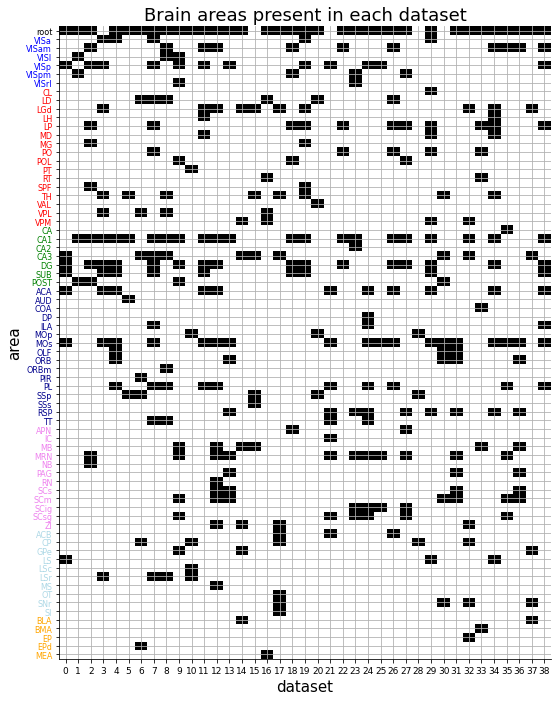

In [11]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)

#Things from Neuromatch


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


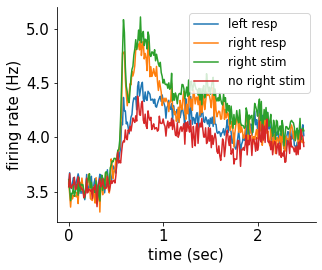

In [ ]:
#@title basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

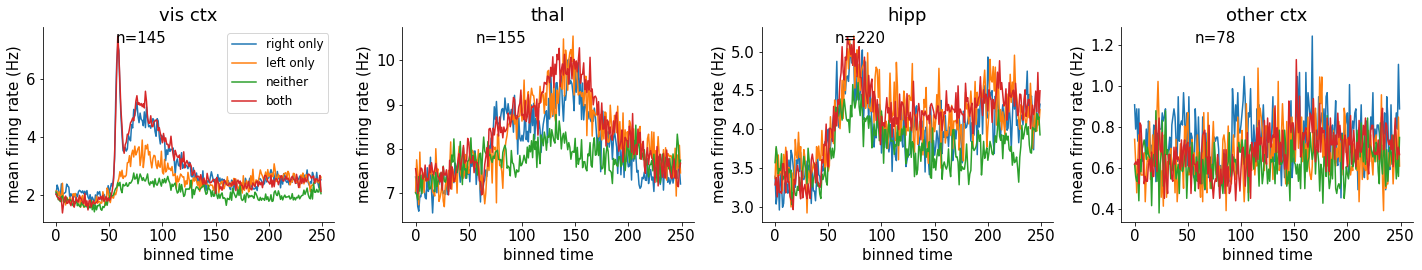

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


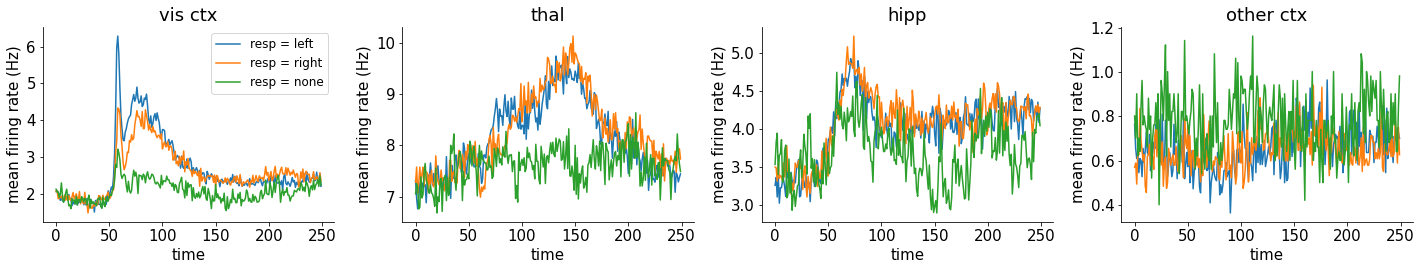

In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

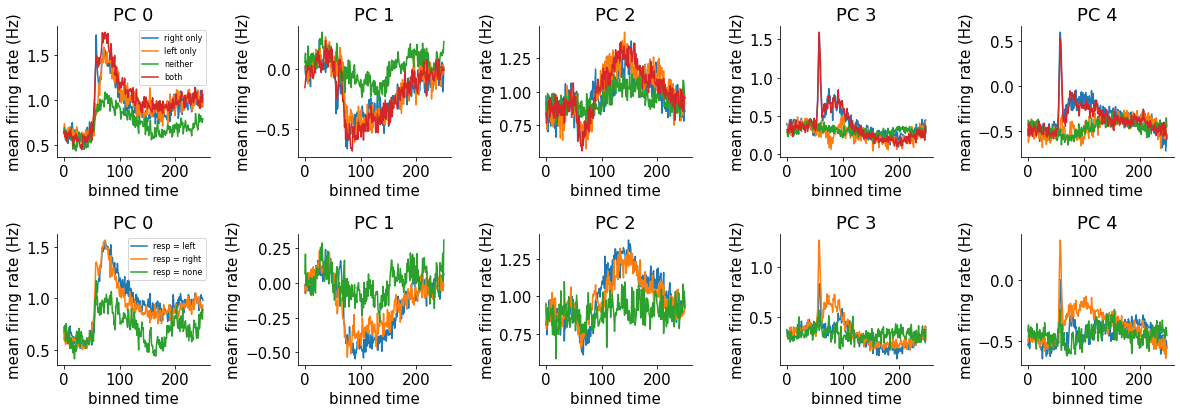

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

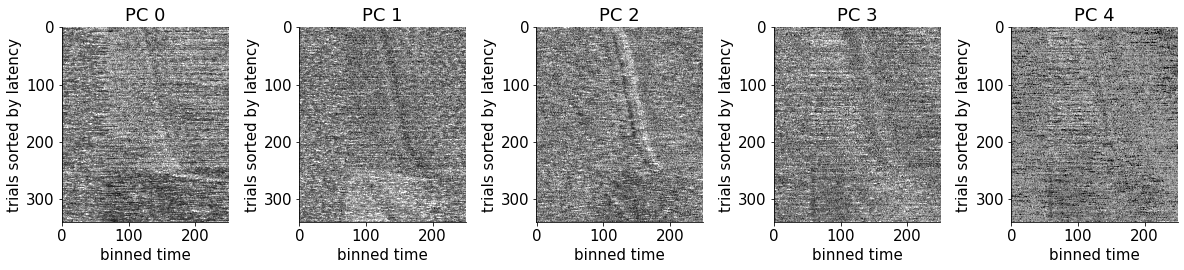

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

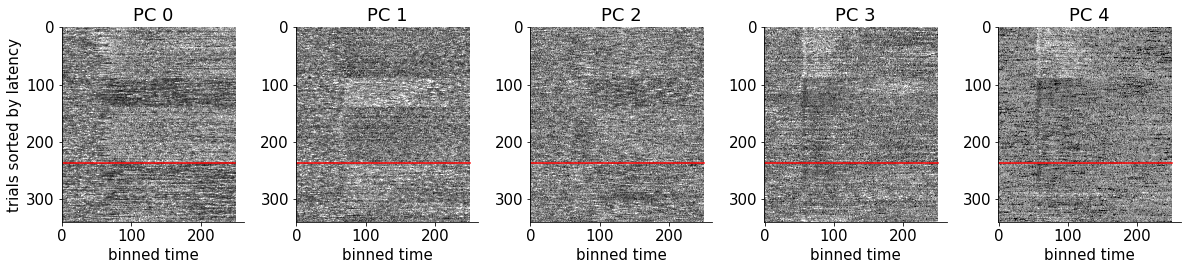

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


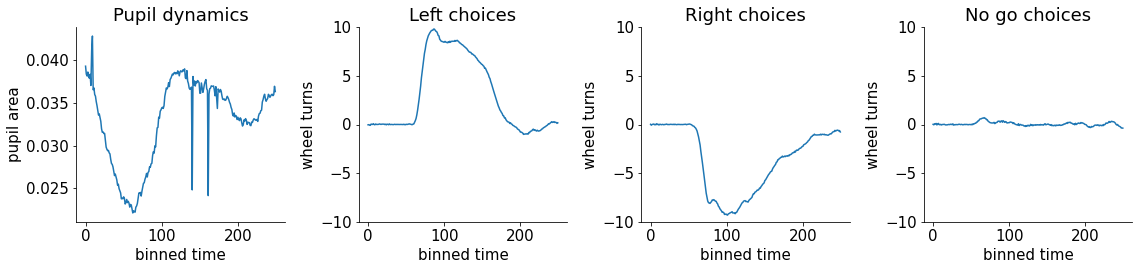

In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


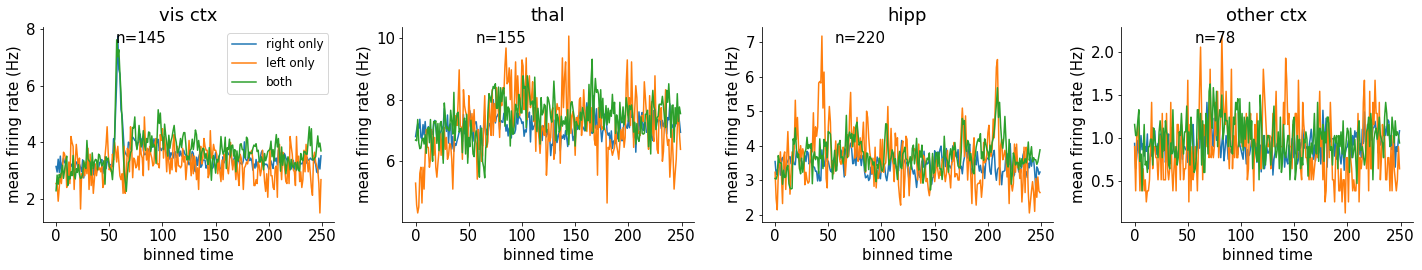

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)


In [ ]:
np.corrcoef(normal_motion,normal_spikes)

array([[1.        , 0.02012618],
       [0.02012618, 1.        ]])

# **Processing Steinmetz data**



## Check which areas are in the experiments

In [ ]:
def unique_areas(areas_list):
  unique_areas = []
  for area in areas_list:
    if area not in unique_areas:
      unique_areas.append(area)
  return(unique_areas)

for exp in range(len(alldat)):
  print(f"Dataset Num: {exp}")
  areas = unique_areas(alldat[exp]['brain_area'])
  print(f"Areas:{areas}")
  print()


Dataset Num: 0
Areas:['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG']

Dataset Num: 1
Areas:['CA1', 'VISl', 'root', 'VISpm', 'POST']

Dataset Num: 2
Areas:['DG', 'VISam', 'MG', 'CA1', 'SPF', 'root', 'LP', 'MRN', 'POST', 'NB', 'VISp']

Dataset Num: 3
Areas:['LGd', 'DG', 'TH', 'SUB', 'VPL', 'VISp', 'CA1', 'VISa', 'LSr', 'ACA', 'MOs']

Dataset Num: 4
Areas:['VISa', 'root', 'CA1', 'SUB', 'DG', 'OLF', 'ORB', 'ACA', 'PL', 'MOs']

Dataset Num: 5
Areas:['AUD', 'root', 'SSp', 'CA1', 'TH']

Dataset Num: 6
Areas:['VPL', 'root', 'CA3', 'LD', 'CP', 'EPd', 'SSp', 'PIR']

Dataset Num: 7
Areas:['ILA', 'TT', 'MOs', 'PL', 'LSr', 'root', 'LD', 'PO', 'CA3', 'VISa', 'CA1', 'LP', 'DG', 'VISp', 'SUB']

Dataset Num: 8
Areas:['TT', 'ORBm', 'PL', 'LSr', 'root', 'CA3', 'VISl', 'CA1', 'TH', 'VISam', 'VPL', 'LD']

Dataset Num: 9
Areas:['MB', 'VISp', 'SCm', 'SCsg', 'POST', 'DG', 'MRN', 'CA1', 'VISl', 'POL', 'root', 'GPe', 'VISrl']

Dataset Num: 10
Areas:['MOp', 'LSc', 'root', 'PT', 'CP', 'LSr']

Dataset Num

##**Get which experiments have our region of Interest**



In [ ]:
exp_rois = []
for exp in range(len(alldat)):
    ROIs = unique_areas(alldat[exp]['brain_area'])
    # if 'BLA' in ROIs:
    #   print (f"BLA recordings in this Exp: {exp}")
    #   exp_rois.append(exp)
    if 'MOs' in ROIs:
      print (f"MOs recordings in this Exp: {exp}")
      exp_rois.append(exp)


Both recordings in this Exp: 3
Both recordings in this Exp: 11
Both recordings in this Exp: 19


## **Old tests**





In [ ]:
# data = alldat[[exp_rois]]
# ephys_features = ['brain_area','ccf','spks','spks_passive']
# behav_features = ['pupil', 'pupil_passive', 'face', 'face_passive']
# all_features = ephys_features + behav_features

# for exp in range(len(data)):
#   data[exp] = data[exp]

In [ ]:
# motion_alltrials = np.sum(data[0]['face'], axis = 1)
# motion_alltrials.shape
# motion_alltrials.flatten()

# spikes_1n = data[0]['spks'][490]
# spikes_1n_alltrials = np.sum(spikes_1n, axis = 0)
# spikes_1n_alltrials.shape
# data[0]['spks'].shape

# spikes_1n = data[0]['spks'][500]
# spikes_1n.shape
# motion_alltrials.shape

# motion = data[0]['face'].flatten()
# motion_passive = data[0]['face_passive'].flatten()

# plt.figure()
# plt.plot(motion_alltrials[0])

# plt.figure()
# plt.plot(spikes_1n_alltrials)

# np.corrcoef(motion_alltrials,spikes_1n_alltrials)

In [ ]:
# pupil_a = data[0]['pupil'][0].flatten()
# pupil_h = data[0]['pupil'][1].flatten()
# pupil_v = data[0]['pupil'][2].flatten()

# plt.figure()
# plt.plot(pupil_v)
# plt.ylim(-3, 3)
# plt.xlim(601, 900)
# plt.figure()
# plt.plot(pupil_h)
# plt.ylim(-3, 3)
# plt.xlim(601, 900)
# plt.figure()
# plt.plot(pupil_a)
# plt.ylim(-0.3, 0.3)
# plt.xlim(601, 900)

In [ ]:
# spikes_1N = data[0]['spks'][450]

# spikes_1N = spikes_1N.flatten()

In [ ]:
# plt.figure()
# plt.plot(spikes_1N)
# # plt.ylim(-1, 5)

# spikes_1N_100ms = np.add.reduceat(spikes_1N, np.arange(0, len(spikes_1N), 10))

# motion_100ms = np.add.reduceat(motion, np.arange(0, len(motion), 10))

In [ ]:
# plt.figure()
# plt.plot(spikes_1N_100ms)
# plt.ylim(-1, 5)
# plt.figure()
# plt.plot(motion_100ms)

In [ ]:
# from sklearn import preprocessing
# normal_motion = preprocessing.normalize([motion_100ms])
# normal_spikes = preprocessing.normalize([spikes_1N_100ms])

# normal_motion = normal_motion[0]
# normal_spikes = normal_spikes[0]

In [ ]:
# plt.scatter(x = list(range(0,len(normal_motion))), y = normal_motion)
# plt.scatter(x = list(range(0,len(normal_spikes))), y = normal_spikes)
# np.correlate(motion_100ms, spikes_1N_100ms)

In [ ]:
#Which areas are in the experiment

def unique_areas(areas_list):
  unique_areas = []
  for area in areas_list:
    if area not in unique_areas:
      unique_areas.append(area)
  return(unique_areas)

for exp in range(len(alldat)):
  print(f"Dataset Num: {exp}")
  areas = unique_areas(alldat[exp]['brain_area'])
  print(f"Areas:{areas}")
  print()

In [ ]:
#Extract the experiment number in which our area was measured and saves it in exp_rois

def experiments_with_area(ROI):
  exp_rois = []
  for exp in range(len(alldat)):
      ROIs = unique_areas(alldat[exp]['brain_area'])
      if area in ROIs:
        exp_rois.append(exp)
        print (f"{area} recordings in this Exp: {exp}")
  return exp_rois


experiments_with_area('VISp')  # <======================================== Check the area of interest
data = alldat[[exp_rois]]

MEA recordings in this Exp: 16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(3,)

In [ ]:
#Reshape the spikes to be Number of neurons, number of trials and 25 100ms bins

def reshape_bins(dataset):
  dataset_reshaped = []

  for index in range(len(dataset)):

    data_0 = dataset[index]
    data_0_spikes = data_0['spks']

    number_of_neurons = data_0_spikes.shape[0]
    number_of_trials = data_0_spikes.shape[1]
    number_of_10ms_bins = data_0_spikes.shape[2]

    data_0_reshaped = data_0_spikes.reshape(number_of_neurons,number_of_trials, int(number_of_10ms_bins/10), 10)
    data_0_reshaped = np.sum(data_0_reshaped, axis = 3)
    dataset_reshaped.append(data_0_reshaped)

    dataset_areas.append(data_0_area)

  return dataset_reshaped

data_reshaped = reshape_bins(data)

#Now, data_reshaped is a 4D matrix with:
# Experiment number
# Neurons
# Trials
# 100ms bins

In [ ]:
def neurons_in_roi (area, dataset):
  dataset_roi = []
  for exp in range(len(data)):
    data_0_area = data[exp]['brain_area']
    neurons_roi = []
    for idx in range(len(data_0_area)):
      if data_0_area[idx] == area:
        neurons_roi.append(idx)
        
    dataset_roi.append(dataset[exp][neurons_roi])

  return dataset_roi
 
data_reshaped_roi = neurons_in_roi('MOs', data_reshaped)

#Now, data_reshaped_roi is a 4D matrix with:
# Experiment number
# Neurons inside ROI
# Trials
# 100ms bins

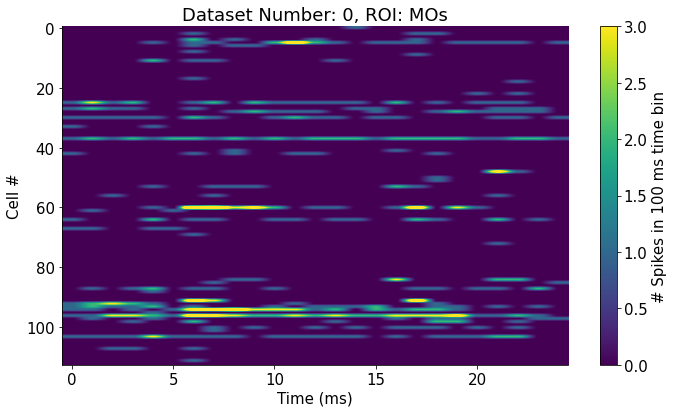

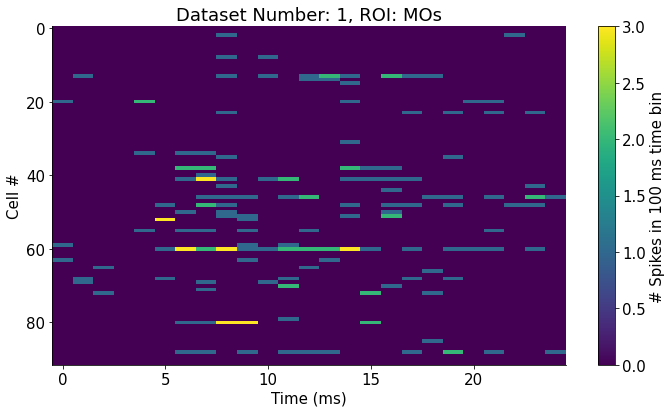

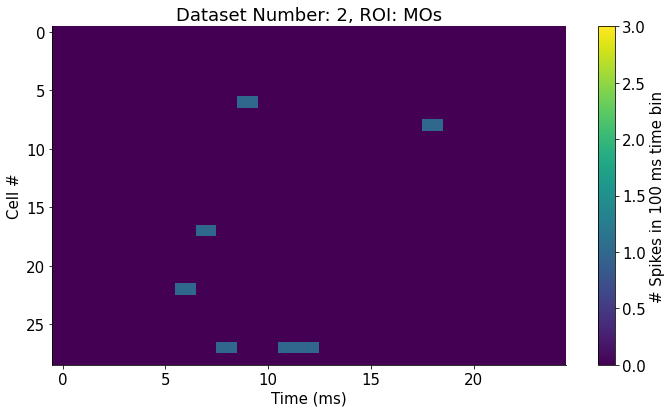

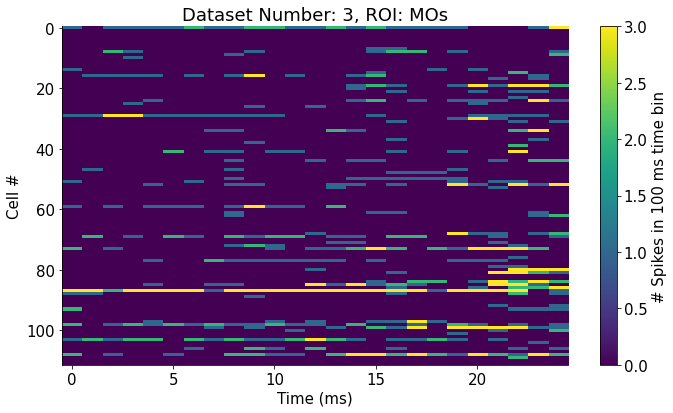

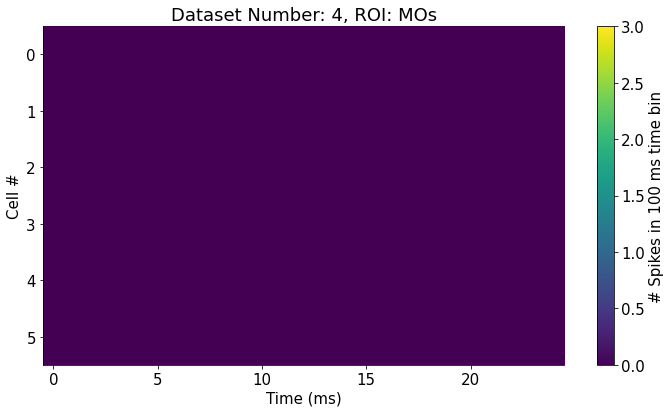

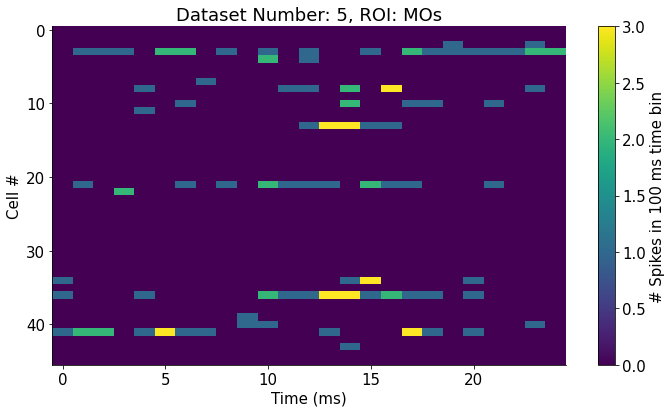

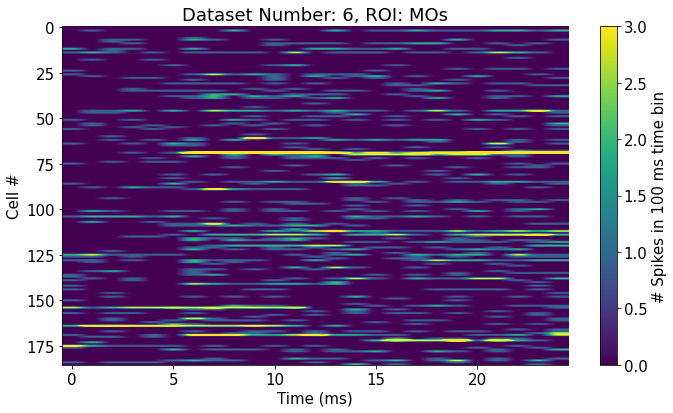

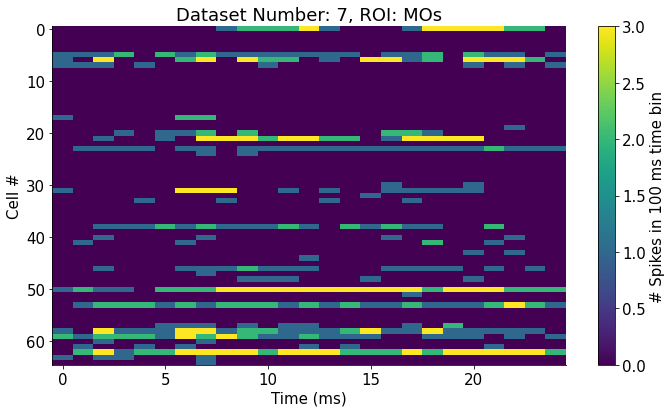

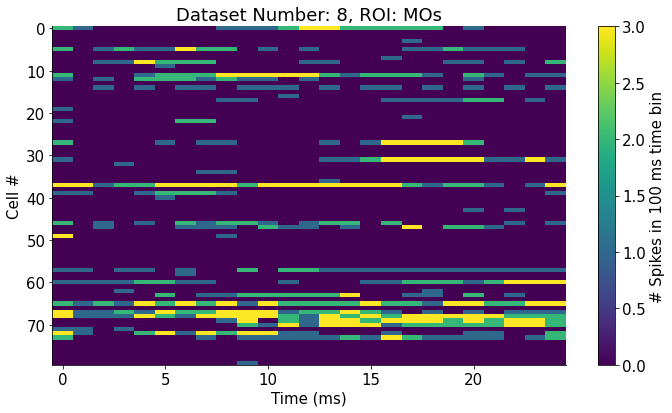

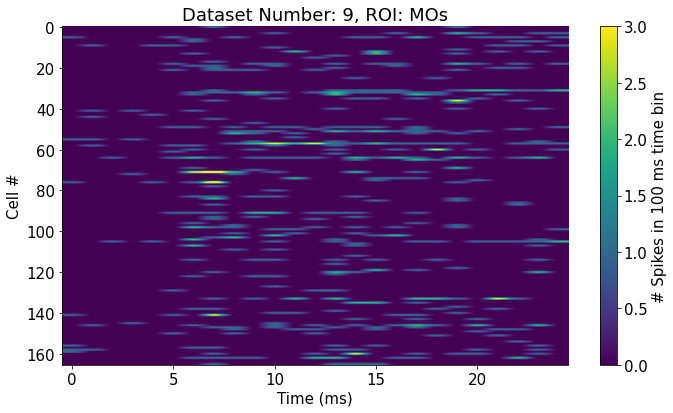

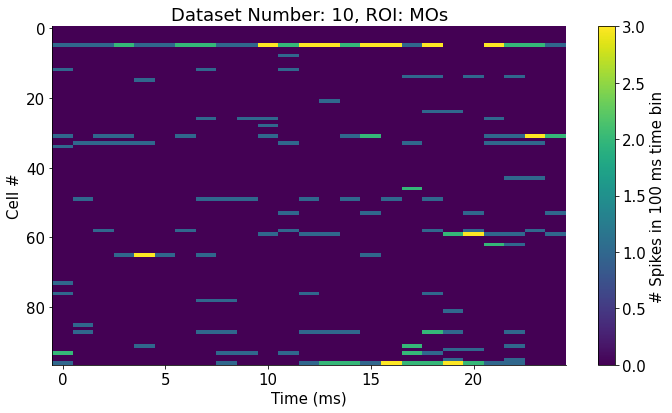

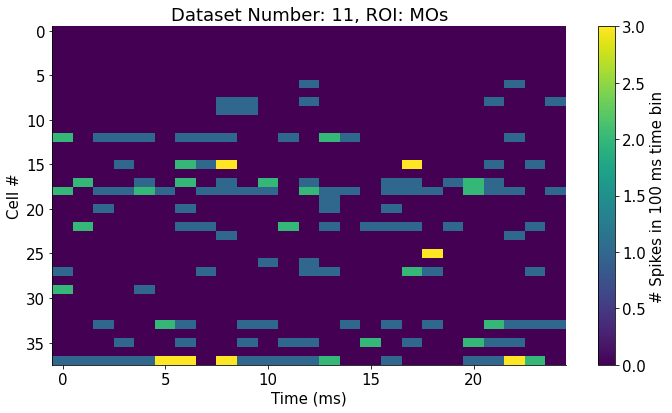

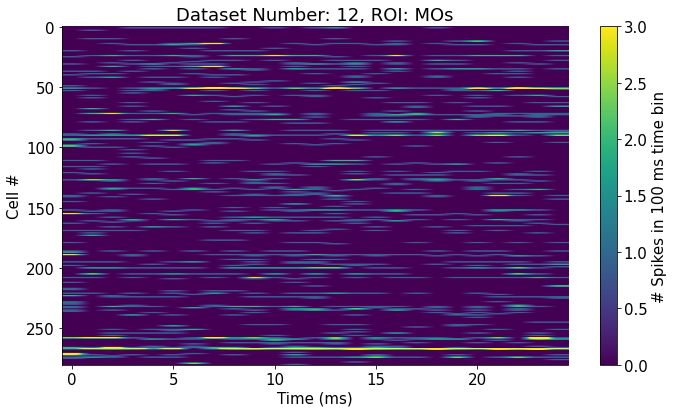

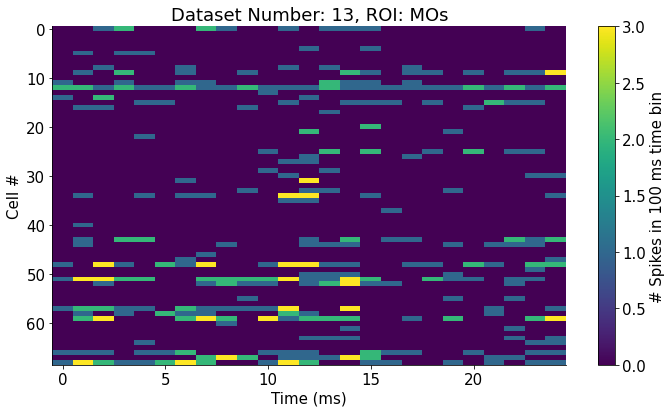

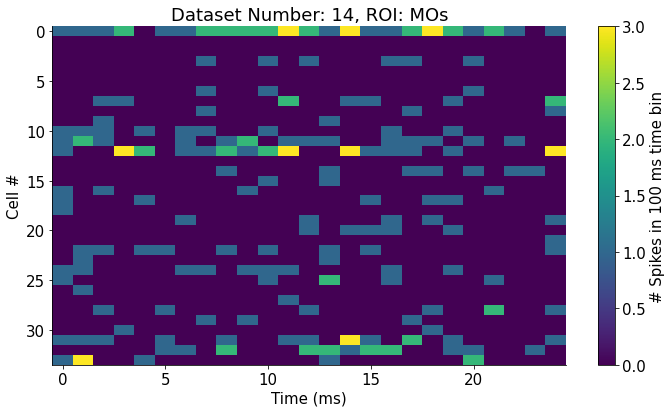

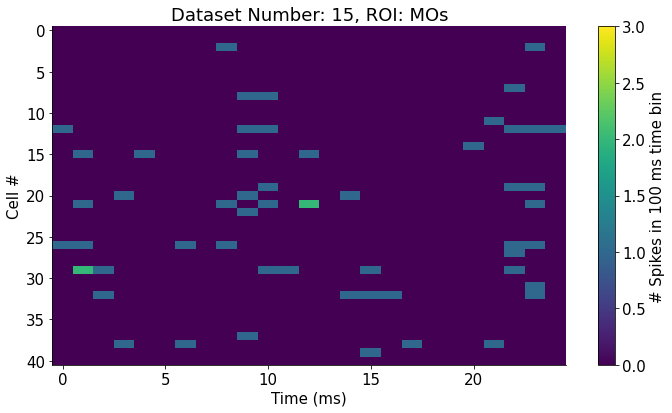

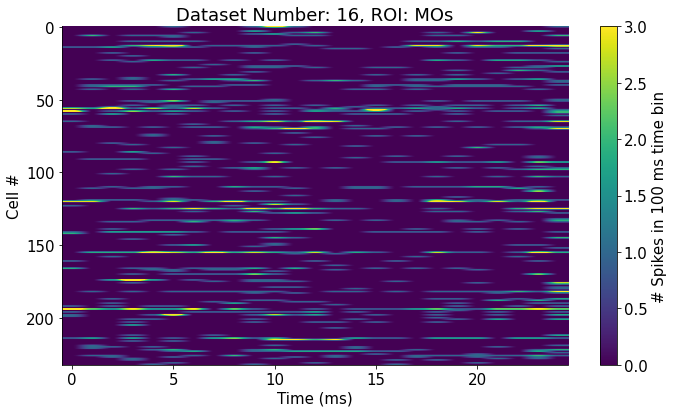

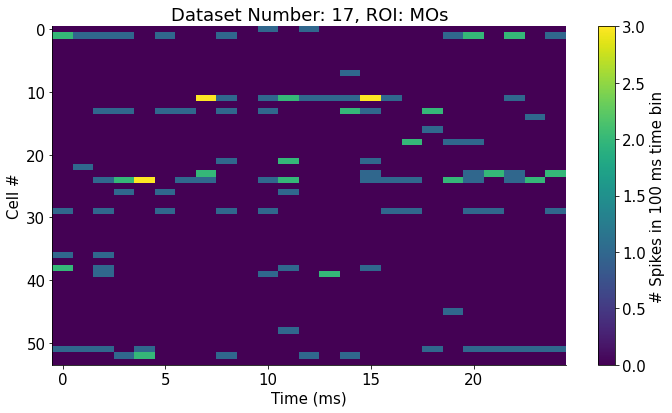

In [ ]:
for exp in range(len(data_reshaped_roi)):
  
  plt.figure(figsize = (10, 6))
  plt.imshow(data_reshaped_roi[exp][:,0,:], cmap='viridis', vmax = 3, vmin=0, aspect='auto')
  plt.xlabel('Time (ms)')
  plt.ylabel('Cell #')
  plt.colorbar(orientation='vertical', label='# Spikes in 100 ms time bin')
  plt.title(f'Dataset Number: {exp}, ROI: MOs')
  plt.show()

(113, 214, 25)

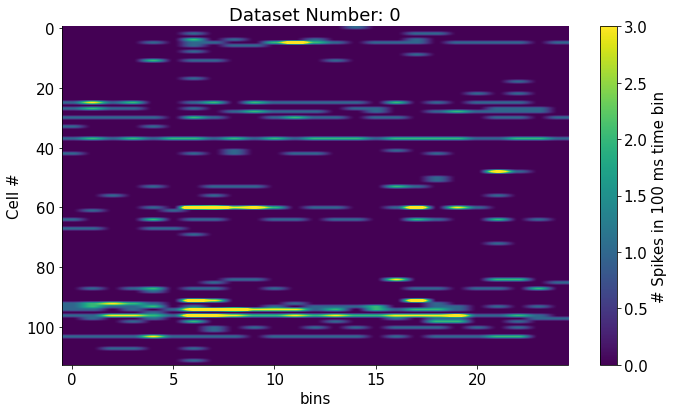

In [ ]:

plt.figure(figsize = (10, 6))
plt.imshow(data_0_roi[:, 0, :], cmap='viridis', vmax = 3, vmin=0, aspect='auto')
plt.xlabel('bins')
plt.ylabel('Cell #')
plt.colorbar(orientation='vertical', label='# Spikes in 100 ms time bin')
plt.title(f'Dataset Number: {0}')
plt.show()

# for exp in range(len(alldat)):
  
#   data_0 = alldat[exp]

#   data_0_area = data_0['brain_area']
#   data_0_spikes = data_0['spks']
  

#   plt.figure(figsize = (10, 6))
#   plt.imshow(data_0_spikes[:, 0, :], cmap='viridis', vmax = 3, vmin=0, aspect='auto')
#   plt.xlabel('Time (ms)')
#   plt.ylabel('Cell #')
#   plt.colorbar(orientation='vertical', label='# Spikes in 0.01 s time bin')
#   plt.title(f'Dataset Number: {exp}')
#   plt.show()

# Seq2Seq

### Load data preprocessed by Klaras loader

In [12]:
import pandas as pd
import numpy as np

!git clone https://github.com/klaragerlei/GoatsOfAllTime.git
import GoatsOfAllTime.data_loader as dl

data_to_analyze = dl.load_data(alldat)

fatal: destination path 'GoatsOfAllTime' already exists and is not an empty directory.
Loading data...


In [13]:
VISp = dl.load_data(alldat, brain_area='VISp', feature='face')
LGd = dl.load_data(alldat, brain_area='LGd', feature='face')
# dat['spks']: neurons by trials by time bins.
# X = data_to_analyze.spikes.iloc[0]
# print(X.shape)
# X_train = X[:,:171,:]
# X_test = X[:,171:,:]
# print(X_train.shape)
# print(X_test.shape)

Loading data...
Loading data...


In [14]:
visp = VISp['spikes'][3]
lgd = LGd['spikes'][3]

In [18]:
X = lgd

# # random_indices_test = random.choice(a, size=None, replace=True, p=None)
# # X: time bins by trials by neurons 
# # X: time bins by trials by neurons 
# print(X.shape)
# perm_idcs = np.random.permutation(X.shape[1])
# train_idx = round(0.8 * X.shape[1])
# X_train = X[:,perm_idcs[:train_idx]]
# X_test = X[:,perm_idcs[train_idx:]]
# print(X_train.shape)
# print(X_test.shape)

print(X.shape)
perm_idcs = np.random.permutation(X.shape[1])
train_idx = round(0.8 * X.shape[1])
X_train = X.transpose(2,1,0)
X_test = X.transpose(2,1,0)
print(X_train.shape)
print(X_test.shape)


(140, 249, 250)
(250, 249, 140)
(250, 249, 140)


In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

  def predict(self, X_test):
    x0_test, x1_test = split_across_neurons(X_test)

    # the network outputs the single-neuron prediction and the latents
    z, y = self(x1_test)

    # our log-likelihood cost
    cost = Poisson_loss(z, x0_test).mean()
    #print('Cost:' + str(cost))
    rpred = z.detach().cpu().numpy()  # predicted output
    return rpred, cost

In [25]:
def split_across_neurons(X):
  neuron_split_idx = X.shape[2] // 2
  x0 = torch.from_numpy(X[:,:,:neuron_split_idx]).to(device).float()
  x1 = torch.from_numpy(X[:,:,neuron_split_idx:neuron_split_idx*2]).to(device).float()
  return x0, x1

# from sklearn.preprocessing import StandardScaler
def product_moment_corr(x,y):
    '''Product-moment correlation for two ndarrays x, y'''
    # x = StandardScaler().fit_transform(x)
    # y = StandardScaler().fit_transform(y)
    n = x.shape[0]
    r = (1/(n-1))*(x.T @ y).sum(axis=0)
    return np.mean(r)

#from scipy.stats import pearsonr
def corr3d(a, b):
  correlations = np.zeros(a.shape[2])
  for i in np.arange(a.shape[2]):
      correlations[i] = product_moment_corr(a[:,:,i],b[:,:,i])
  return np.mean(correlations)

In [26]:
# todo x0 should be the spikes and x1 the behaviour
# x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
# x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

x0 = torch.from_numpy(X_train).to(device).float()
x1 = torch.from_numpy(X_test).to(device).float()


NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# let's use 10 latent components
ncomp = 10

# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))  # !!!!!!!!!!!

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.005)

In [27]:
# you can keep re-running this cell if you think the cost might decrease further

# we define the Poisson log-likelihood loss
def Poisson_loss(lam, spk):
  return lam - spk * torch.log(lam)

iterations = []
correlations = []
costs = []
costs_test = []

niter = 1000
for k in range(niter):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our log-likelihood cost
  cost = Poisson_loss(z, x0).mean()

  # train the network as usual
  cost.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 100 == 0:
    rpred_train = z.detach().cpu().numpy()  # predicted output
    rpred_test, cost_test = net.predict(X_test)
    correlation = corr3d(rpred_train, rpred_test)
    iterations.append(k)
    correlations.append(correlation)
    costs.append(cost.item())
    costs_test.append(cost_test.item())
    print(f'iteration {k}, cost {cost.item():.4f}, cost_test {cost_test.item():.4f}, correlation {correlation:.4f}')
  

  rpred = z.detach().cpu().numpy()  # predicted output

RuntimeError: ignored

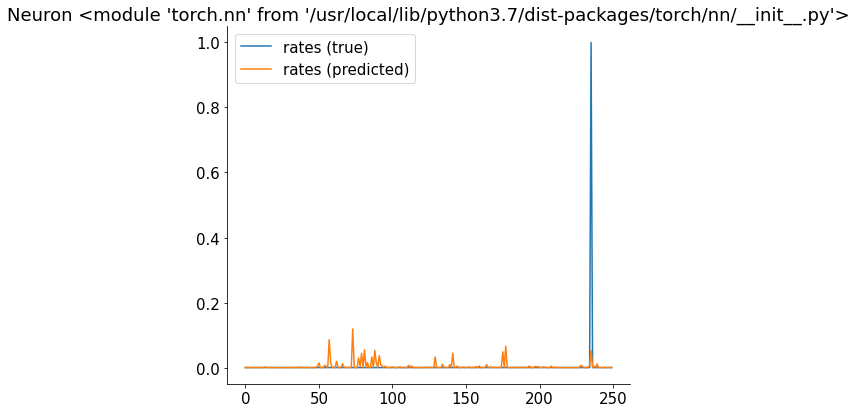

In [ ]:
def plot_prediction_vs_data(neuron_id=4, trial_id=78):
  rpred = z.detach().cpu().numpy()
  x0_rates = x0.detach().cpu().numpy()

  plt.figure(figsize=(10, 6))
  plt.plot(x0_rates[:,trial_id, neuron_id])
  plt.plot(rpred[:,trial_id, neuron_id])
  # plt.plot(-.5 + x[:, nn, 0]/4) # these are spikes we don't have that

  plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
  plt.title(f'Neuron {nn}')
  plt.show()
plot_prediction_vs_data()